# $\theta$ sweep test
- This notebook created Figure 5 in the paper.
- This notebook was compiled when Qiskit was still at version 0.23, therefore, some parts may require modifications to ensure compatibility with the lastest version

# Import

In [1]:
from qiskit import IBMQ
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
IBMQ.load_account()
import numpy as np
import pandas as pd

In [2]:
from qiskit import Aer, BasicAer, execute, transpile, assemble
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import os, time
import matplotlib.pyplot as plt

# Setup
- The circuit used in this test is the circuit of the third set of conditions, in which $R_y(-\theta)$ is applied to all four qubits.
- The $\theta$ value runs in the range (0, $\pi$) (rad) with the step is $\pi/180$ (rad).

In [3]:
# Theta sweep
# Define arbitrary number of qubits and ancilla qubits
n = 4  # Change this value as needed
num_pairs = n

# Define theta range
pi = np.pi
start = 0
end = pi
step = np.pi/180
theta = np.arange(start, end, step)

q = QuantumRegister(n, 'q')
c = ClassicalRegister(n + num_pairs, 'c')
anc = QuantumRegister(num_pairs, 'anc')

backend = Aer.get_backend('qasm_simulator')
num_shots = 2048*200

counts = {}
count_shop = []

# Loop over theta values
for i in theta:
    qc = QuantumCircuit(q, c, anc)
    qc.ry(i, q)
    
    # Apply MCT gates based on the number of qubits
    for j in range(num_pairs):
        control_qubits = [q[j % n], q[(j+1) % n]]
        qc.mct(control_qubits, anc[j], mode='noancilla')
    
    qc.ry(-i, q)
    qc.measure(q, c[:n])
    qc.measure(anc, c[n:n + num_pairs])
    
    job = execute(qc, backend=backend, shots=num_shots)
    result = job.result()
    counts[i] = result.get_counts()
    count_shop.append(counts[i])

# Process the counts
d = 0
for count in count_shop:
    for m in range (num_pairs):
        for k, v in list(count.items()):
            j = 0
            for p in range (1):
                if len(k) > 0 and k[0] == '1':
                    d += v
                    del count[k]
                    break
                j+=1

        for k, v in list(count.items()):
            count[k[1:]] = count.pop(k)

# Data (Circuits' results of corresponding $\theta$ )

In [4]:
print (count_shop)

[{'0000': 409600}, {'0000': 409600}, {'0000': 409600}, {'0000': 409599}, {'0000': 409593, '0110': 3, '1001': 1, '0011': 1}, {'0000': 409590, '1001': 2, '0011': 2}, {'0000': 409574, '0011': 4, '1100': 5, '1001': 2, '0110': 5}, {'0000': 409553, '1100': 5, '0011': 5, '1001': 8, '0110': 11}, {'0000': 409539, '1100': 5, '0011': 6, '1001': 5, '0110': 10, '0100': 1}, {'0000': 409474, '0011': 12, '1100': 21, '1001': 15, '0110': 15, '0010': 1}, {'0000': 409417, '0110': 28, '0011': 22, '1100': 19, '1001': 21, '0001': 1, '0010': 1}, {'0000': 409336, '0110': 26, '1001': 33, '0011': 27, '1100': 35, '0001': 1, '1011': 1, '0111': 1, '0010': 2}, {'0000': 409205, '1001': 41, '1100': 56, '0011': 39, '0110': 42, '0100': 3, '1011': 3, '0111': 1, '0010': 1, '0001': 2, '1000': 1}, {'0000': 409071, '1100': 69, '0110': 59, '1110': 1, '1001': 50, '0011': 69, '1000': 1, '0010': 7, '0001': 2, '0100': 4}, {'0000': 408921, '0110': 90, '1110': 2, '1001': 67, '1100': 93, '1011': 1, '0010': 2, '0011': 68, '0001': 7, 

In [12]:
df1 = pd.DataFrame(count_shop)
df1.to_excel("theta_sweep_test_population_data.xlsx", index=False)

# Finding the maximum value of $P_{success}$ and its corresponding $\theta$ value
- With each value of $\theta$, $P_{success}$ is calculated as the sum of probability of nine states of interest, specifically, $\left|1100\right\rangle, \left|1101\right\rangle, \left|1001\right\rangle, \left|0110\right\rangle, \left|1110\right\rangle, \left|0011\right\rangle, \left|0111\right\rangle, \left|1011\right\rangle$, and $\left|1111\right\rangle$.
- The following cell prints the states of interestcorresponding to each $\theta$ value, as well as the maximum value of $P_{success}$ and its associated $\theta_{max}$ (in degree).

In [5]:
dict_list = count_shop  

def count_consecutive_ones(key):
    return max(len(segment) for segment in key.split('0'))

# Initialize variables to track the maximum p and its index
max_p = 0
max_index = -1


for index, dictionary in enumerate(dict_list):
    selected_keys = []
   
    sum_values = sum(dictionary.values())

    # Check if sum_values is zero
    if sum_values == 0:
        continue  # Skip this dictionary if sum_values is zero

    # Calculate p 
    p = 0

    for key, value in dictionary.items():
        count_1s = key.count('1')
        # Check for keys with (n - 2) consecutive '1's
        if count_1s == (n - 2) and '1' * (n - 2) in key:
            p += value / sum_values
            selected_keys.append(key)
        elif count_1s == n - 2: # Exactly (n - 2) '1's
            if key[0] == '1' and key[-1] == '1':  # '1' at both ends
                adjacent_1s = sum(1 for i in range(1, n-1) if key[i] == '1' and (key[i-1] == '1' or key[i+1] == '1'))
                if adjacent_1s == n - 4:  # (n - 4) adjacent '1's
                    p += value / sum_values
                    selected_keys.append(key)
        # Check for keys with more than (n - 2) '1's
        elif count_1s > (n - 2):
            p += value / sum_values
            selected_keys.append(key)
    print(selected_keys)
    # Check if the current p is the largest
    if p > max_p:
        max_p = p
        max_index = index

max_p, max_index

[]
[]
[]
[]
['0110', '1001', '0011']
['1001', '0011']
['0011', '1100', '1001', '0110']
['1100', '0011', '1001', '0110']
['1100', '0011', '1001', '0110']
['0011', '1100', '1001', '0110']
['0110', '0011', '1100', '1001']
['0110', '1001', '0011', '1100', '1011', '0111']
['1001', '1100', '0011', '0110', '1011', '0111']
['1100', '0110', '1110', '1001', '0011']
['0110', '1110', '1001', '1100', '1011', '0011']
['1001', '0110', '1110', '0011', '1100', '1011', '1101', '0111']
['1100', '0011', '1001', '1110', '0110', '1011', '1101', '0111']
['1110', '0011', '1100', '0110', '1001', '1011', '1101', '0111']
['0110', '1001', '0011', '1100', '1110', '1011', '0111', '1101']
['0011', '1100', '1110', '0110', '1001', '1101', '1011', '0111']
['0011', '1111', '1011', '1001', '1110', '0110', '1100', '1101', '0111']
['0110', '1011', '1001', '0011', '1110', '1101', '1100', '0111']
['1001', '0110', '1111', '0011', '1100', '1110', '0111', '1011', '1101']
['1100', '1111', '1110', '1001', '0011', '0110', '0111', 

(0.09131562722694189, 77)

# Measurement results of the circuit using the $\theta_{max}$

In [6]:
print(dict_list[max_index])

{'0000': 152171, '0010': 13967, '0001': 14288, '0100': 14224, '0011': 3308, '1010': 8947, '1111': 1276, '1000': 14346, '0110': 3278, '1100': 3279, '1101': 2127, '0101': 9030, '0111': 2176, '1001': 3256, '1110': 2036, '1011': 2073}


- $\theta_{max}$ value in radian unit

In [8]:
print(theta[max_index])

1.3439035240356338


# Plotting the sweep test result

In [9]:
from matplotlib.ticker import FuncFormatter
# Extract p values
p_values = []
for d in dict_list:
    
    sum_values = sum(d.values())
    # Check if sum_values is zero to avoid division by zero
    if sum_values == 0:
        p = 0  # If sum_values is zero, set p to 0
    else:
        # Calculate p for the current dictionary
        p = 0
        for key, value in d.items():
            count_1s = key.count('1')
            # Check for keys with (n - 2) consecutive '1's
            if count_1s == (n - 2) and '1' * (n - 2) in key:
                p += value / sum_values
            elif count_1s == n - 2: # Exactly (n - 2) '1's
                if key[0] == '1' and key[-1] == '1':  # '1' at both ends
                    adjacent_1s = sum(1 for i in range(1, n-1) if key[i] == '1' and (key[i-1] == '1' or key[i+1] == '1'))
                    if adjacent_1s == n - 4:  # (n - 4) adjacent '1's
                        p += value / sum_values
            # Check for keys with more than (n - 2) '1's
            elif count_1s > (n - 2):
                p += value / sum_values
    
    p_values.append(p)
max_p = max(p_values)
max_index_p = p_values.index(max_p)
# Indices
indices = range(len(dict_list))

plt.figure(figsize=(200, 110))  # Adjust figure size
plt.plot(indices, p_values, marker='o', linestyle='-', color='r', linewidth=55, label='P_success')
max_theta = max_index 
plt.scatter(max_index_p, max_p, color='black', s=100000, label=f'Max value: {max_p*100:.2f}%', edgecolor='white', linewidth=55)
plt.axvline(x=max_index, color='blue', linestyle='--', linewidth=55, label=f'x = {max_theta}')

def to_percent(y, _):
    return f'{y * 100:.2f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.xlabel(r"$ \theta\ (\mathrm{^{\circ})} $", fontsize=400, labelpad=50)
plt.ylabel('Success probability (%)', fontsize=350, labelpad=50)
 
xticks = list(range(0, 180, 30))
xticks.append(max_index)

plt.xticks(sorted(xticks))
 
plt.tick_params(axis='x', labelsize=350) 

yticks = plt.gca().get_yticks().tolist()  # Get current y-ticks

  
plt.yticks(yticks)
plt.tick_params(axis='y', labelsize=350) 

ax = plt.gca()
ax.spines['bottom'].set_color('black')  
ax.spines['bottom'].set_linewidth(20)    
ax.spines['left'].set_color('black')    
ax.spines['left'].set_linewidth(10)      
ax.spines['top'].set_color('black')  
ax.spines['top'].set_linewidth(10)    
ax.spines['right'].set_color('black')    
ax.spines['right'].set_linewidth(10)      

ax.xaxis.set_tick_params(pad=30)
ax.yaxis.set_tick_params(pad=30)

ax.tick_params(axis='x', length=100, width=10, direction='out')
ax.tick_params(axis='y', length=100, width=10, direction='out')

legend = plt.legend(fontsize=350, loc='upper right')
legend.get_frame().set_linewidth(5)  
legend.get_frame().set_edgecolor('black')  

plt.show()


# Peak vicinity

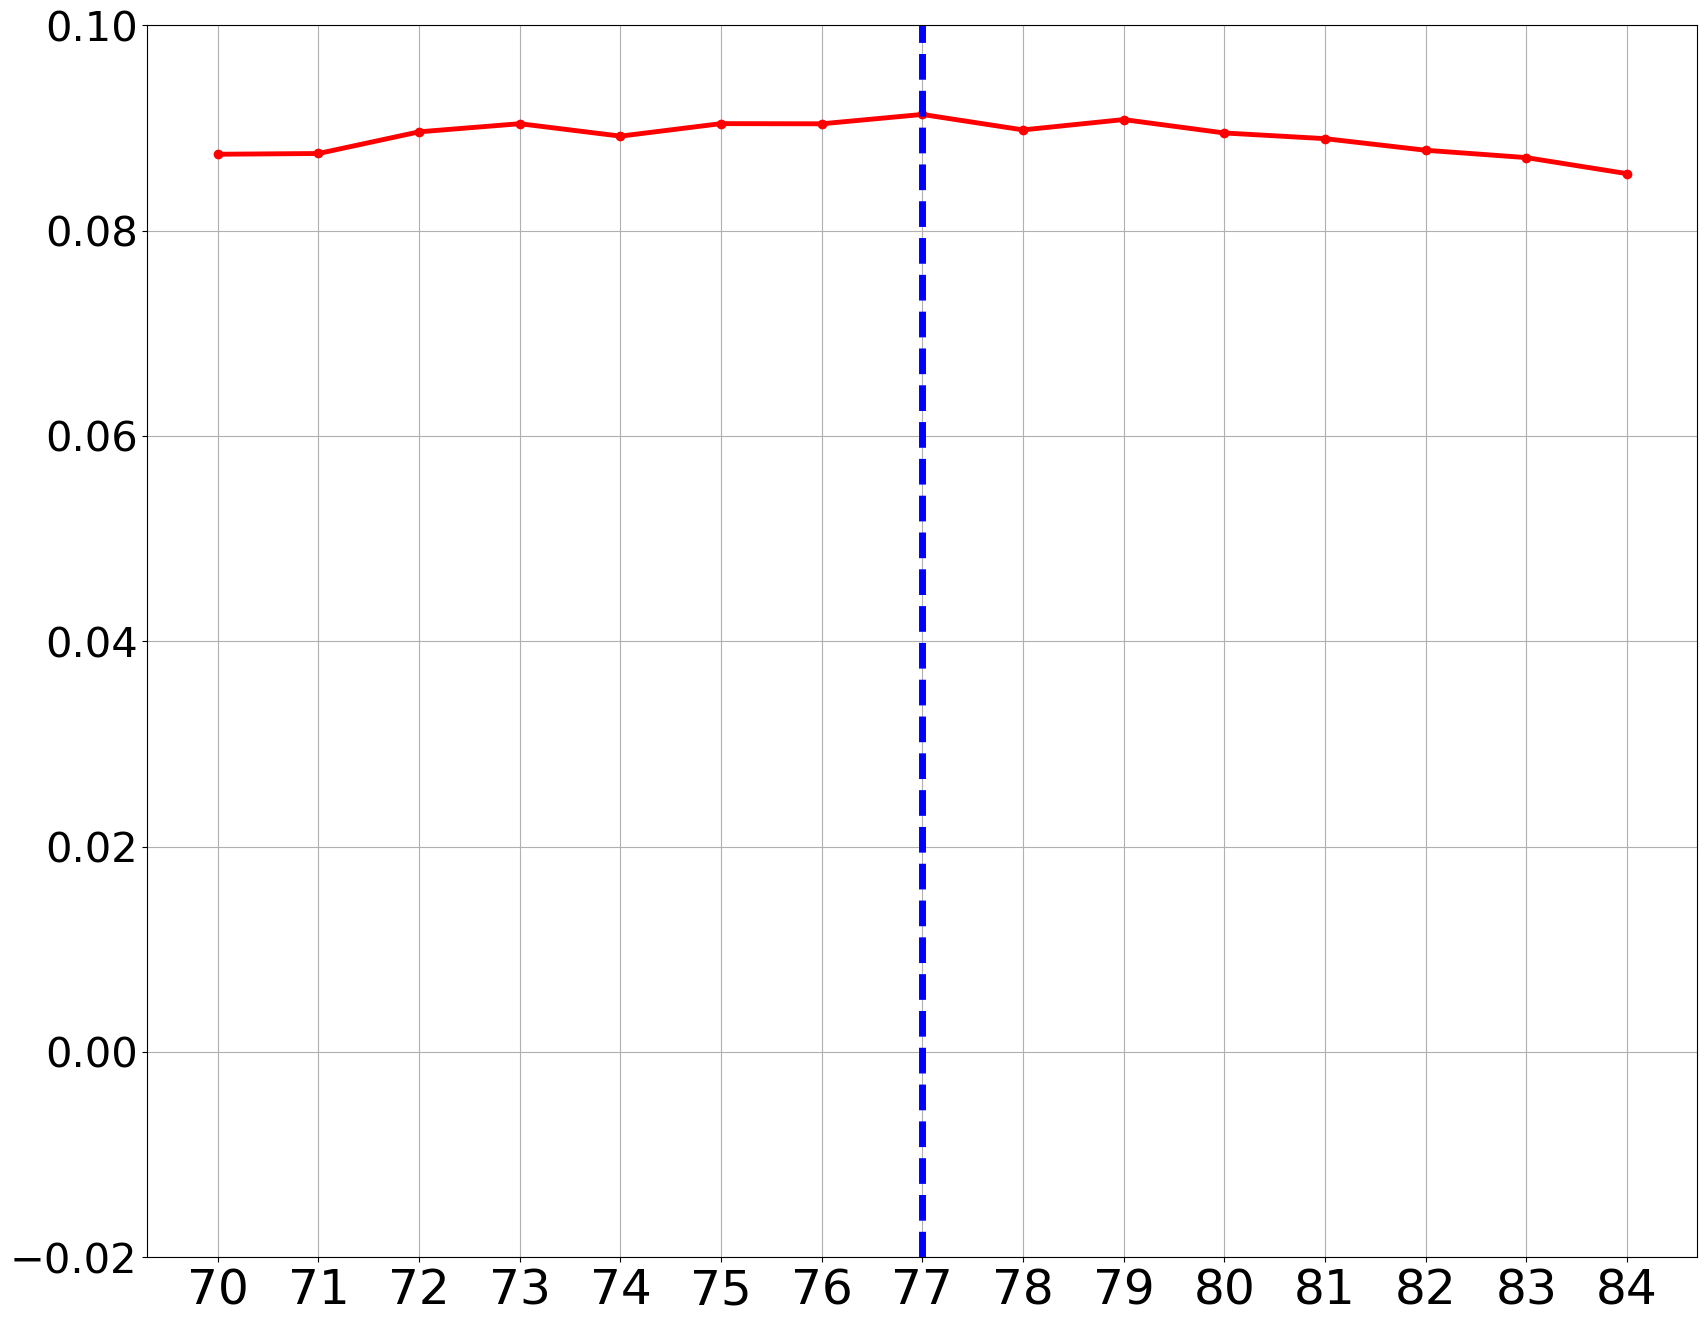

In [10]:
# zoom in
start_index = 70
end_index = 85

p_values = []
for i in range(start_index, end_index):
    d = dict_list[i]
        
    sum_values = sum(d.values())
    # Check if sum_values is zero to avoid division by zero
    if sum_values == 0:
        p = 0  # If sum_values is zero, set p to 0
    else:
        # Calculate p for the current dictionary
        p = 0
        for key, value in d.items():
            count_1s = key.count('1')
            # Check for keys with (n - 2) consecutive '1's
            if count_1s == (n - 2) and '1' * (n - 2) in key:
                p += value / sum_values
            elif count_1s == n - 2: # Exactly (n - 2) '1's
                if key[0] == '1' and key[-1] == '1':  # '1' at both ends
                    adjacent_1s = sum(1 for i in range(1, n-1) if key[i] == '1' and (key[i-1] == '1' or key[i+1] == '1'))
                    if adjacent_1s == n - 4:  # (n - 4) adjacent '1's
                        p += value / sum_values
            # Check for keys with more than (n - 2) '1's
            elif count_1s > (n - 2):
                p += value / sum_values
    
    p_values.append(p)

# Indices
indices = range(start_index, end_index)
plt.figure(figsize=(20, 16))  
plt.plot(indices, p_values, marker='o', linestyle='-', color='r', linewidth=3.5, label='p values')
plt.axvline(x=max_index, color='blue', linestyle='--', linewidth=5, label='x = max_index')
plt.xticks(indices)  
plt.tick_params(axis='x', labelsize=35) 
plt.yticks(yticks)
plt.tick_params(axis='y', labelsize=30) 
plt.grid(True)
plt.show()

